## Process IWRAP

IWRAP

In [1]:
# General
import glob
import re
import os.path
# import warnings
# warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import copy

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm
import pandas as pd

# Data treatment
from datetime import datetime
from scipy.optimize import curve_fit
from scipy.interpolate import griddata

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
# Paths & Params
PTHS = {
    'iwp_dir': '/home/arthur/data/tropical_cyclones/IWRAP/',
    'dsg_pth': '/home/arthur/data/tropical_cyclones/SAR/parametric_dataset/dsg.nc',
    'sar_pth': '/home/arthur/results/PINNS4TC/process_data/s1b-ew-owi-ca-20210907t214630-20210907t215005-000003-0369AB_sw_al122021_cyclone_gd.nc',
    'sar_dir': '/home/arthur/data/tropical_cyclones/SAR/S1_RS2_RCM/sar_files/',
}

In [3]:
# Open data
dsg = xr.open_dataset(PTHS['dsg_pth'])

# Open Larry
ds  = dsg.where(dsg.name == 'LARRY', drop=True).sortby('time').isel(time=4)
dsc = xr.open_dataset(PTHS['sar_pth']).isel(time=0)

In [4]:
#########################
###       PLOT        ###
#########################
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def getColorMap(rgbFile="medspiration.rgb"):
    '''
    Load a RGB palette provided in ascii file
    '''
    colors = []
    nbCol  = 0
    for line in open( rgbFile ):
        r,g,b = [int(c) for c in line.split()]
        colors.append( [r/255.,g/255.,b/255.] )
        nbCol += 1
    return(mpl.colors.ListedColormap(colors, name="custom", N=nbCol))

palette = '/home/arthur/scripts/tools/high_wind_speed.pal'
cwnd         = getColorMap(rgbFile=palette)
normalizer   = Normalize(0, 80)

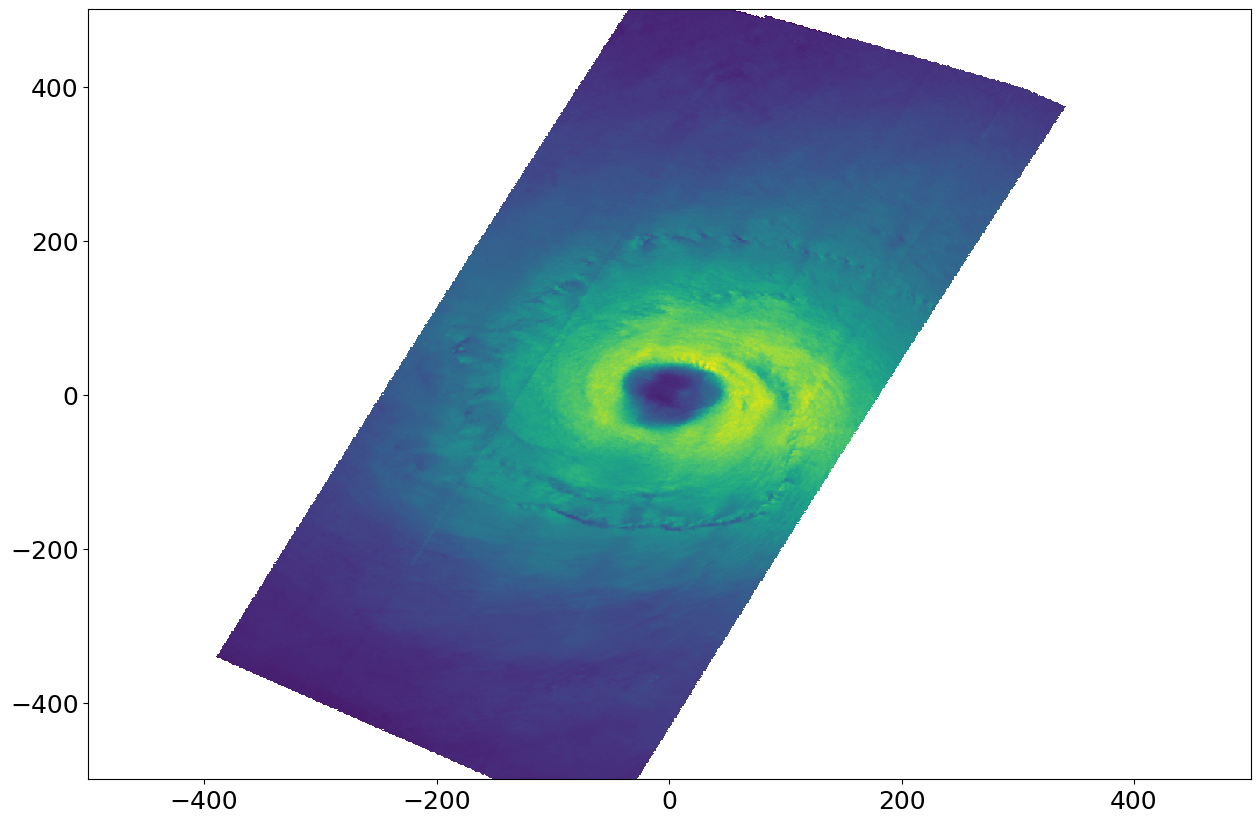

In [5]:
# Test 1
plt.pcolormesh(dsc.x / 1000, dsc.y / 1000, dsc.wind_speed)

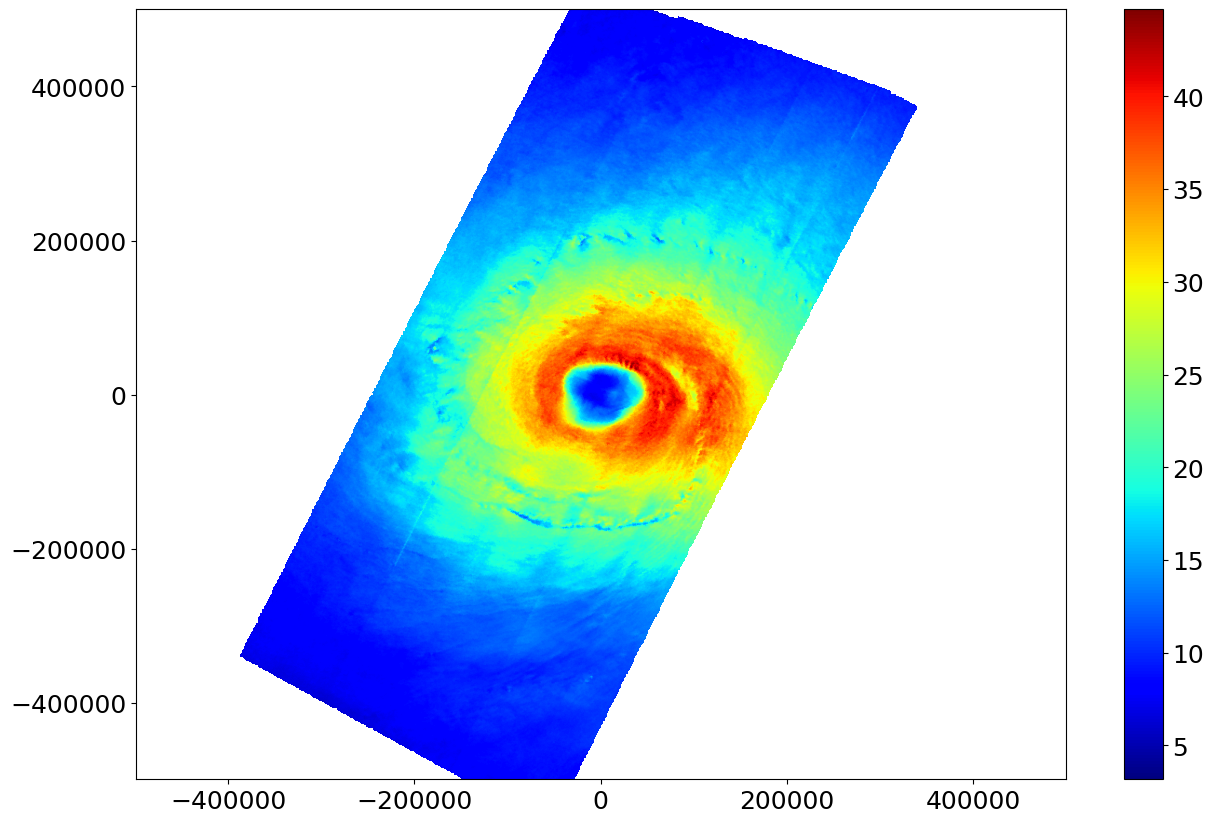

In [6]:
# Test 2
plt.imshow(
    dsc.wind_speed.values,
    extent = [dsc.x.min(), dsc.x.max(), dsc.y.min(), dsc.y.max()],
    aspect="auto",
    cmap="jet",
    origin='lower',
)
plt.colorbar()

### 1) SAR

/tmp/ipykernel_21145/4285646306.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap         = mpl.cm.get_cmap('PuOr') # Spectral


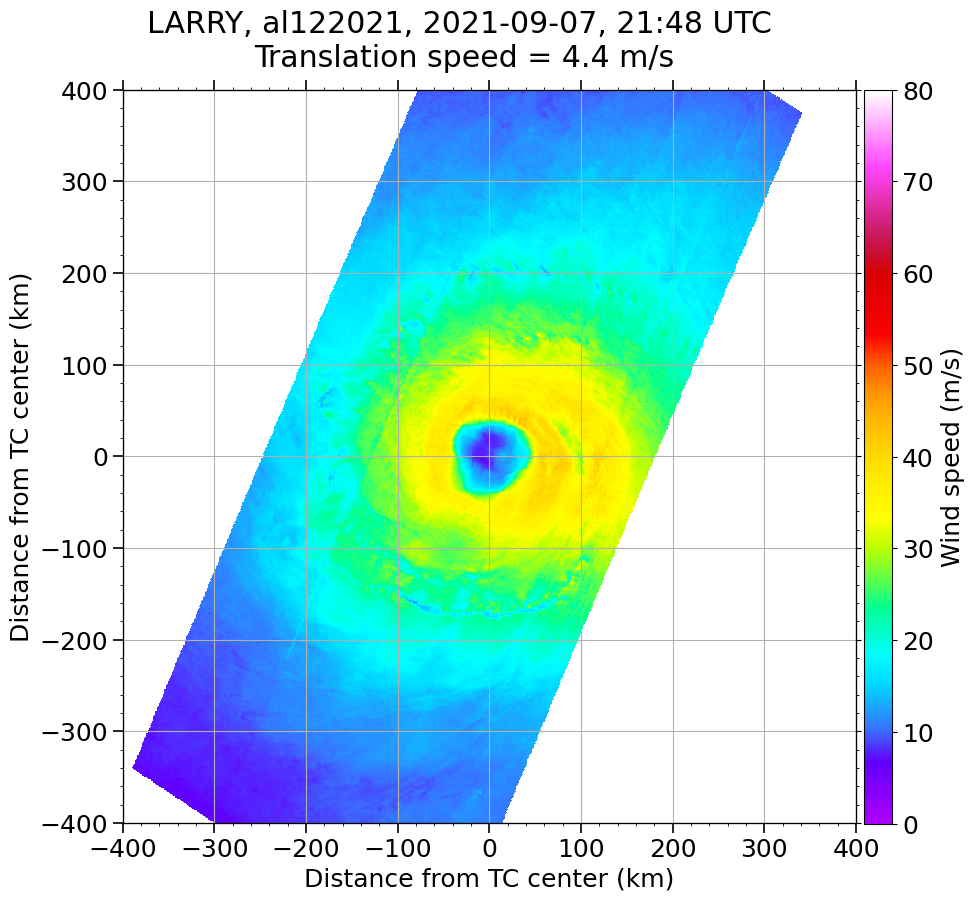

In [7]:
############
### Plot ###
############
fig          = plt.figure(figsize=(20, 20))
gs           = GridSpec(2, 1, hspace=0.1, wspace=0.01)
cmap         = mpl.cm.get_cmap('PuOr') # Spectral
normalizer   = Normalize(0, 80)
ax_lims2D    = 400
ts           = pd.to_datetime(str(ds.time.values)) 
d            = ts.strftime('%Y-%m-%d, %H:%M')
plt.suptitle('{}, {}, {} UTC \nTranslation speed = {:.1f} m/s'.format(ds.name.item(), ds.id.item(), d, ds.speed), y=0.92)

### Plot SAR
ax           = fig.add_subplot(gs[0, 0])
im           = ax.pcolormesh(dsc.x / 1000, dsc.y / 1000, dsc.wind_speed, cmap=cwnd, norm=normalizer)

# Axes
ax.set_xlim(-ax_lims2D, ax_lims2D);ax.set_ylim(-ax_lims2D, ax_lims2D)
ax.set_ylabel(r'Distance from TC center (km)')
ax.set_xlabel(r'Distance from TC center (km)')
ax.set_box_aspect(1)
ax.minorticks_on()
ax.tick_params(length=7, width=1.2)
ax.grid()

ax2 = ax.twinx().twiny() 
ax2.set_xlim(-ax_lims2D, ax_lims2D);ax2.set_ylim(-ax_lims2D, ax_lims2D)
ax2.minorticks_on()
ax2.tick_params(axis='both', length=7, width=1.2)
ax2.set_box_aspect(1)
ax2.set_yticklabels([])
ax2.set_xticklabels([])

# Colorbar
cb_ax = fig.add_axes([0.7, 0.513, 0.014, 0.367])
cbar  = fig.colorbar(im, cax=cb_ax)
cbar.set_label(r'Wind speed (m/s)', rotation=90)
cbar.ax.get_yaxis().labelpad=5

### 2) IWRAP

Ku1 is limited to z <= 1.5km. Well suited for lower levels.

Ku2 has the higher-resolution retrievals for the upper levels.

In [8]:
from pyproj import CRS, Geod

### FUNCTIONS
def get_polar_theta(forward_az):
    '''INPUT: forward_az: 0° is North, 90° is East;
    OUTPUT: theta: 0° is East, 90° is North'''
    theta = (90 - forward_az) % 360 # 0° is North, 90° is East
    return theta

def pol2cart(r, th):
    x = r * np.cos(th)
    y = r * np.sin(th)
    return x, y

def get_new_aircraft_coords_based_on_storm_motion(diwp, storm_dir, storm_speed, time_cen, lon_cen, lat_cen):
    '''storm_dir: usually float(ds.storm_dir_ibt), i.e degrees east of north
    storm_speed: usually float(ds.storm_speed_ibt), i.e m/s
    time_cen: usually ds.time, i.e np.datetime64 indicating the time of the considered center point
    lon_cen, lat_cen: usually float(ds.lon) and float(ds.lat), i.e coordinates of the storm center (degrees East and North)
    '''
    # Temps écoulé depuis le temps d'acquisition SAR
    dt              = diwp.time - time_cen
    diwp['dt_scds'] = xr.DataArray(
        data=np.array(dt.dt.days * 24 * 3600 + dt.dt.seconds),
        dims=['bin']
    )
    diwp.dt_scds.attrs['description'] = 'Temps écoulé depuis le temps d acquisition SAR'

    # New longitudes/latitudes after moving x meters to a specified direction
    geod_wgs84            = CRS("epsg:4326").get_geod()
    new_lons, new_lats, _ = geod_wgs84.fwd(lons=diwp.lon, lats=diwp.lat, az=np.ones_like(diwp.lon) * storm_dir, dist=-diwp.dt_scds * storm_speed)
    
    diwp['new_lon']       = xr.DataArray(data=new_lons, dims=['bin'])
    diwp['new_lat']       = xr.DataArray(data=new_lats, dims=['bin'])
    diwp.new_lon.attrs['description'] = 'longitude of the point after correcting for storm motion'
    diwp.new_lat.attrs['description'] = 'latitude of the point after correcting for storm motion'

    # Compute polar coordinates
    geod_wgs84        = CRS("epsg:4326").get_geod()
    forward_az, _, dr = geod_wgs84.inv(np.ones_like(diwp.lon) * lon_cen, np.ones_like(diwp.lat) * lat_cen, diwp.new_lon, diwp.new_lat)
    th                = get_polar_theta(forward_az) # r is dr
    
    diwp['r']         = xr.DataArray(data=dr, dims=['bin'])
    diwp['th']        = xr.DataArray(data=th, dims=['bin'])
    diwp.r.attrs['description']  = 'radius of the point after correcting for storm motion'
    diwp.th.attrs['description'] = 'azimuth of the point after correcting for storm motion'

    # Compute cartesian coordinates
    x, y      = pol2cart(dr, np.deg2rad(th))
    diwp['x'] = xr.DataArray(data=x, dims=['bin'])
    diwp['y'] = xr.DataArray(data=y, dims=['bin'])
    diwp.x.attrs['description'] = 'x of the point after correcting for storm motion'
    diwp.y.attrs['description'] = 'y of the point after correcting for storm motion'

    return diwp

In [9]:
file1 = 'IWRAP_3Dsp_ku1_20210907I1_20230522T193045.nc'
file2 = 'IWRAP_3Dsp_ku2_20210907I1_20230522T175900.nc'
file3 = 'IWRAP_3Dsp_ku2_20210907I1_20230531T173056.nc'

In [10]:
diwp1 = xr.open_dataset(PTHS['iwp_dir'] + file1)
diwp2 = xr.open_dataset(PTHS['iwp_dir'] + file2)
diwp3 = xr.open_dataset(PTHS['iwp_dir'] + file3)

# Filter data (cf. mail Joe Sapp)
# diwp1 = diwp1.where(diwp1.quality >= 7)
# diwp2 = diwp2.where(diwp1.quality >= 7)
# diwp3 = diwp3.where(diwp1.quality >= 7)

In [11]:
### Correct aircraft and storm relative motion
diwp1 = get_new_aircraft_coords_based_on_storm_motion(diwp1, float(ds.storm_dir_ibt), float(ds.storm_speed_ibt), ds.time, float(ds.lon), float(ds.lat))
diwp2 = get_new_aircraft_coords_based_on_storm_motion(diwp2, float(ds.storm_dir_ibt), float(ds.storm_speed_ibt), ds.time, float(ds.lon), float(ds.lat))
diwp3 = get_new_aircraft_coords_based_on_storm_motion(diwp3, float(ds.storm_dir_ibt), float(ds.storm_speed_ibt), ds.time, float(ds.lon), float(ds.lat))

### Add radial and tangential wind components
for diwpX in [diwp1, diwp2, diwp3]:
    diwpX['rad_wind'] = diwpX.hws * np.sin(np.deg2rad(diwpX.hwdir + diwpX.th))
    diwpX['tan_wind'] = diwpX.hws * np.cos(np.deg2rad(diwpX.hwdir + diwpX.th))

In [12]:
# ### Save
# diwp1.to_netcdf(PTHS['sav_dir'] + 'adjusted_{}'.format(file1))
# diwp2.to_netcdf(PTHS['sav_dir'] + 'adjusted_{}'.format(file2))
# diwp3.to_netcdf(PTHS['sav_dir'] + 'adjusted_{}'.format(file3))

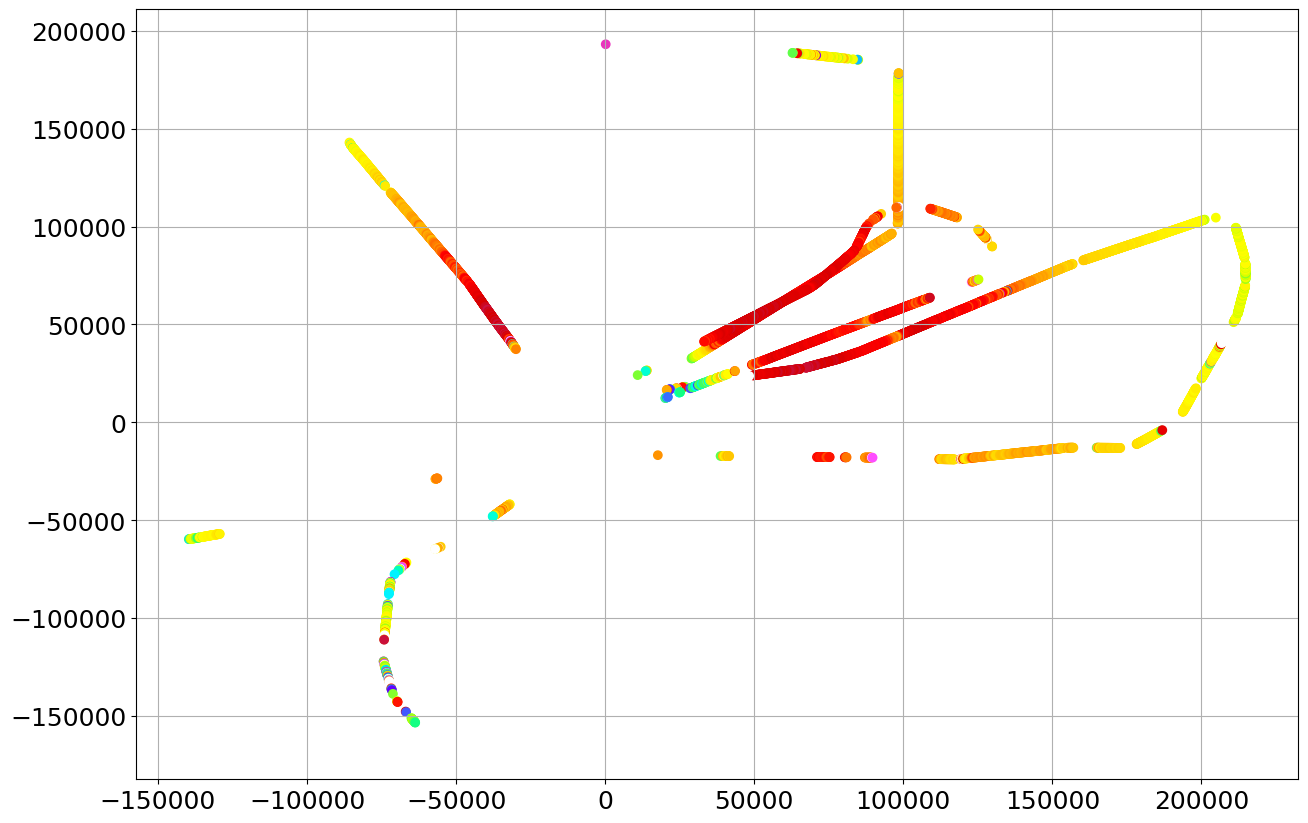

In [13]:
plt.scatter(diwp1.isel(height=34).x, diwp1.isel(height=34).y, c=diwp1.isel(height=34).hws, cmap=cwnd, norm=normalizer)
plt.grid()

/tmp/ipykernel_21145/802636495.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap         = mpl.cm.get_cmap('PuOr') # Spectral


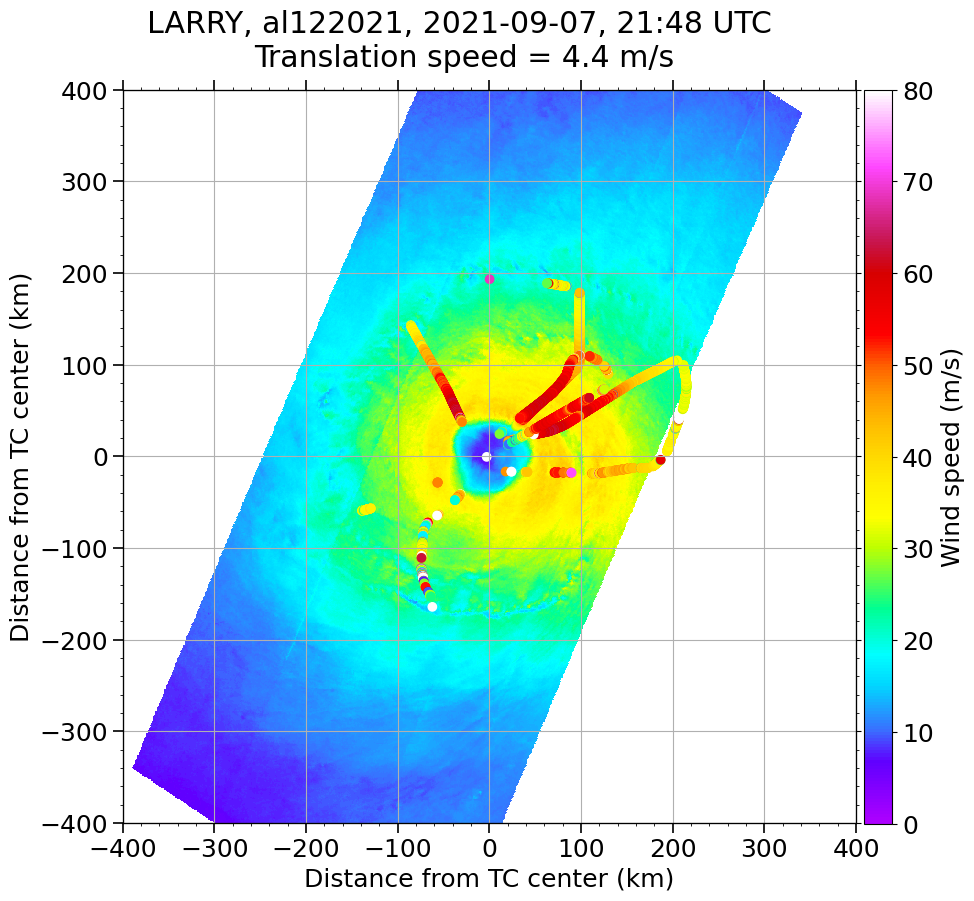

In [14]:
############
### Plot ###
############
fig          = plt.figure(figsize=(20, 20))
gs           = GridSpec(2, 1, hspace=0.1, wspace=0.01)
cmap         = mpl.cm.get_cmap('PuOr') # Spectral
normalizer   = Normalize(0, 80)
ax_lims2D    = 400
ts           = pd.to_datetime(str(ds.time.values)) 
d            = ts.strftime('%Y-%m-%d, %H:%M')
plt.suptitle('{}, {}, {} UTC \nTranslation speed = {:.1f} m/s'.format(ds.name.item(), ds.id.item(), d, ds.speed), y=0.92)

### Plot SAR
ax           = fig.add_subplot(gs[0, 0])
im           = ax.pcolormesh(dsc.x / 1000, dsc.y / 1000, dsc.wind_speed, cmap=cwnd, norm=normalizer)
ax.scatter(diwp1.isel(height=34).x / 1000, diwp1.isel(height=34).y / 1000, c=diwp1.isel(height=34).hws, cmap=cwnd, norm=normalizer)

# Axes
ax.set_xlim(-ax_lims2D, ax_lims2D);ax.set_ylim(-ax_lims2D, ax_lims2D)
ax.set_ylabel(r'Distance from TC center (km)')
ax.set_xlabel(r'Distance from TC center (km)')
ax.set_box_aspect(1)
ax.minorticks_on()
ax.tick_params(length=7, width=1.2)
ax.grid()

ax2 = ax.twinx().twiny() 
ax2.set_xlim(-ax_lims2D, ax_lims2D);ax2.set_ylim(-ax_lims2D, ax_lims2D)
ax2.minorticks_on()
ax2.tick_params(axis='both', length=7, width=1.2)
ax2.set_box_aspect(1)
ax2.set_yticklabels([])
ax2.set_xticklabels([])

# Colorbar
cb_ax = fig.add_axes([0.7, 0.513, 0.014, 0.367])
cbar  = fig.colorbar(im, cax=cb_ax)
cbar.set_label(r'Wind speed (m/s)', rotation=90)
cbar.ax.get_yaxis().labelpad=5

### Comparison with CyclObs algorithm

We find that both codes are consistent.

In [ ]:
def sfmr_translate(sfmr_df, track_df, acq_time, sfmr_lon, sfmr_lat, sfmr_time):
    """
    Modify longitude/latitude of each SFMR point to adapt it to the satellite acquisition by removing
    the cyclone translation during the SFMR flight.

    Parameters
    ----------
    sfmr_df : pd.DataFrame
              DataFrame containing SFMR data with datetime as index.
    track_df : pd.DataFrame
               DataFrame containing cyclone track data.
    acq_time : datetime.datetime
               Satellite acquisition datetime.
    sfmr_lon : str
                Name of sfmr column to access longitude data
    sfmr_lat : str
                Name of sfmr column to access latitude data
    sfmr_time : str
                Name of sfmr time index

    Returns
    -------
    pd.DataFrame
        DataFrame containing SFMR data with datetime as index with translated lon/lat.
    """
    lon = "lon"
    lat = "lat"

    # logger.debug("Translating SFMR data...")
    track_df_ts = track_df.drop(columns=["geometry", "date"])
    track_df_ts = track_df_ts.set_index("datetime")

    # Upsample track data to know the position of cyclone every second.
    track_df_ts = track_df_ts.resample("1s").asfreq().interpolate()

    # Remove timezone info...
    acq_time = acq_time.replace(tzinfo=None)

    # Get cyclone position at time of satellite acquisition
    cyc_pos_sat = track_df_ts.loc[acq_time][[lon, lat]]

    # logger.debug(f"Cyclone position at satellite acquisition time : {cyc_pos_sat}")

    sfmr_df = sfmr_df.reset_index()
    # Compute cyclone position at each sfmr acquisition time
    # cyc_pos_sfmr = track_df_ts.loc[sfmr_df[sfmr_time]][[lon, lat]]
    cyc_pos_sfmr = track_df_ts[[lon, lat]].reindex(
        sfmr_df[sfmr_time], 
        method='nearest'
    ).reset_index(drop=True)

    # logger.debug(f"Cyclone position at each sfmr acquisition time : {cyc_pos_sfmr}")

    # Compute the lon/lat distance between the cyclone position at time of acquisition and
    # cyclone position for each SFMR point
    pos_diff = pd.DataFrame()
    pos_diff[lon] = cyc_pos_sat[lon] - cyc_pos_sfmr[lon]
    pos_diff[lat] = cyc_pos_sat[lat] - cyc_pos_sfmr[lat]
    pos_diff = pos_diff.reset_index()
    # logger.debug(f"Position diff : {pos_diff}")

    # Adding the offsets to for each SFMR point
    # The goal is to relocalize each SFMR point correctly into the instant-acquisition data lon/lat grid.
    # If the cyclone has moved 5 meters on the right between the time of SFMR point acquisition and the time of SAR
    # acquisition, we move the SFMR point 5 meter to the right. Thus, we can consider that this new offseted point
    # has been acquired at the same time as the SAR acquisition.
    sfmr_df[sfmr_lon] = sfmr_df[sfmr_lon] + pos_diff[lon]
    sfmr_df[sfmr_lat] = sfmr_df[sfmr_lat] + pos_diff[lat]

    err_df = sfmr_df[sfmr_df[sfmr_lon] > 180]
    if len(err_df.index > 0):
        raise ValueError("Longitude > 180")

    return sfmr_df


In [24]:
def get_storm_track_forecast(ds, freq_hours=1, window_hours=6):
    """
    Computes storm center positions for a given window around the current time.
    
    Parameters:
    - ds: xarray.Dataset containing 'lon', 'lat', 'storm_dir_ibt', and 'storm_speed_ibt'
    - freq_hours: Frequency of the points in hours (default: 1)
    - window_hours: How many hours back and forward to compute (default: 6)
    
    Returns:
    - track_ds: xarray.Dataset with the time-series of storm locations
    """
    
    # Extract parameters from ds
    lon_cen     = float(ds.lon)
    lat_cen     = float(ds.lat)
    storm_dir   = float(ds.storm_dir_ibt)   # Degrees East of North
    storm_speed = float(ds.storm_speed_ibt) # m/s
    time_cen    = ds.time.values
    
    # Define time offsets in seconds (-6h to +6h)
    offsets_hours   = np.arange(-window_hours, window_hours + freq_hours, freq_hours)
    offsets_seconds = offsets_hours * 3600
    
    # Initialize Geod (WGS84)
    geod_wgs84 = CRS("epsg:4326").get_geod()
    
    # Calculate distances: distance = speed * time
    # Note: fwd(dist) takes positive distance to move along the azimuth.
    distances = storm_speed * offsets_seconds
    
    # Project new coordinates
    # We use a constant azimuth (storm_dir) for all points
    new_lons, new_lats, _ = geod_wgs84.fwd(
        lons=np.full_like(offsets_seconds, lon_cen, dtype=float),
        lats=np.full_like(offsets_seconds, lat_cen, dtype=float),
        az=np.full_like(offsets_seconds, storm_dir, dtype=float),
        dist=distances
    )
    
    # Create time array
    times = time_cen + np.array(offsets_hours, dtype='timedelta64[h]')
    
    # # Package into an xarray Dataset for consistency with your workflow
    # track_ds = xr.Dataset(
    #     data_vars={
    #         'lon': (['time'], new_lons),
    #         'lat': (['time'], new_lats),
    #         'offset_hours': (['time'], offsets_hours)
    #     },
    #     coords={
    #         'time': times
    #     },
    #     attrs={
    #         'description': f'Storm track centered at {time_cen}',
    #         'storm_speed_ms': storm_speed,
    #         'storm_dir_deg': storm_dir
    #     }
    # )

    # 4. Create the DataFrame
    track_df = pd.DataFrame({
        'datetime': time_cen + pd.to_timedelta(offsets_hours, unit='h'),
        'lon': new_lons,
        'lat': new_lats,
        'date': (time_cen + pd.to_timedelta(offsets_hours, unit='h')).date, # Placeholder for the .drop()
        'geometry': None # Placeholder for the .drop()
    })

    return track_df
    
    # return track_ds

# --- Example Usage ---
track_df = get_storm_track_forecast(ds)
# print(track)

In [32]:
def prep_xarray_for_sfmr_translate(ds):
    """
    Converts 1D variables from diwp1 xarray.Dataset to a pandas.DataFrame
    compatible with sfmr_translate.
    """
    # 1. Select only the 1D variables (those that only have 'bin' as a dimension)
    # This avoids issues with the 2D 'height' variables like 'w', 'hws', 'Ze'
    one_d_vars = [v for v in ds.data_vars if ds[v].dims == ('bin',)]
    
    # 2. Convert to DataFrame
    df = ds[one_d_vars].to_dataframe()
    
    # 3. Ensure the time column is the index (as required by sfmr_translate)
    # If 'time' is a variable, we set it as index. 
    if 'time' in df.columns:
        df = df.set_index('time')
    
    # 4. Clean up any multi-indexing caused by the 'bin' coordinate
    if isinstance(df.index, pd.MultiIndex):
        df = df.reset_index(level='bin', drop=True)
        
    return df

# --- EXECUTION ---

# 1. Convert your diwp1 to a dataframe
sfmr_df = prep_xarray_for_sfmr_translate(diwp1)

In [42]:
# 3. Run the translation
# Note: we use 'lon' and 'lat' (original aircraft coords) 
# and 'time' (which is now the index)
translated_sfmr_df = sfmr_translate(
    sfmr_df=sfmr_df,
    track_df=track_df,
    acq_time=pd.to_datetime(ds.time.values),
    sfmr_lon='lon',
    sfmr_lat='lat',
    sfmr_time='time'
)

In [44]:
# --- Step A: Convert translated lon/lat to Cartesian (km) ---
geod_wgs84 = CRS("epsg:4326").get_geod()

# Compute distance and azimuth from storm center to translated points
# lon_cen, lat_cen are the storm center coordinates from 'ds'
forward_az, _, dr = geod_wgs84.inv(
    np.full(len(translated_sfmr_df), float(ds.lon)), 
    np.full(len(translated_sfmr_df), float(ds.lat)), 
    translated_sfmr_df['lon'].values, 
    translated_sfmr_df['lat'].values
)

# Convert azimuth to math theta and then to Cartesian
th_trans = get_polar_theta(forward_az)
x_trans, y_trans = pol2cart(dr, np.deg2rad(th_trans))

# Add to the dataframe for easy access
translated_sfmr_df['x_km'] = x_trans / 1000
translated_sfmr_df['y_km'] = y_trans / 1000

/tmp/ipykernel_21145/3076420746.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap         = mpl.cm.get_cmap('PuOr') # Spectral


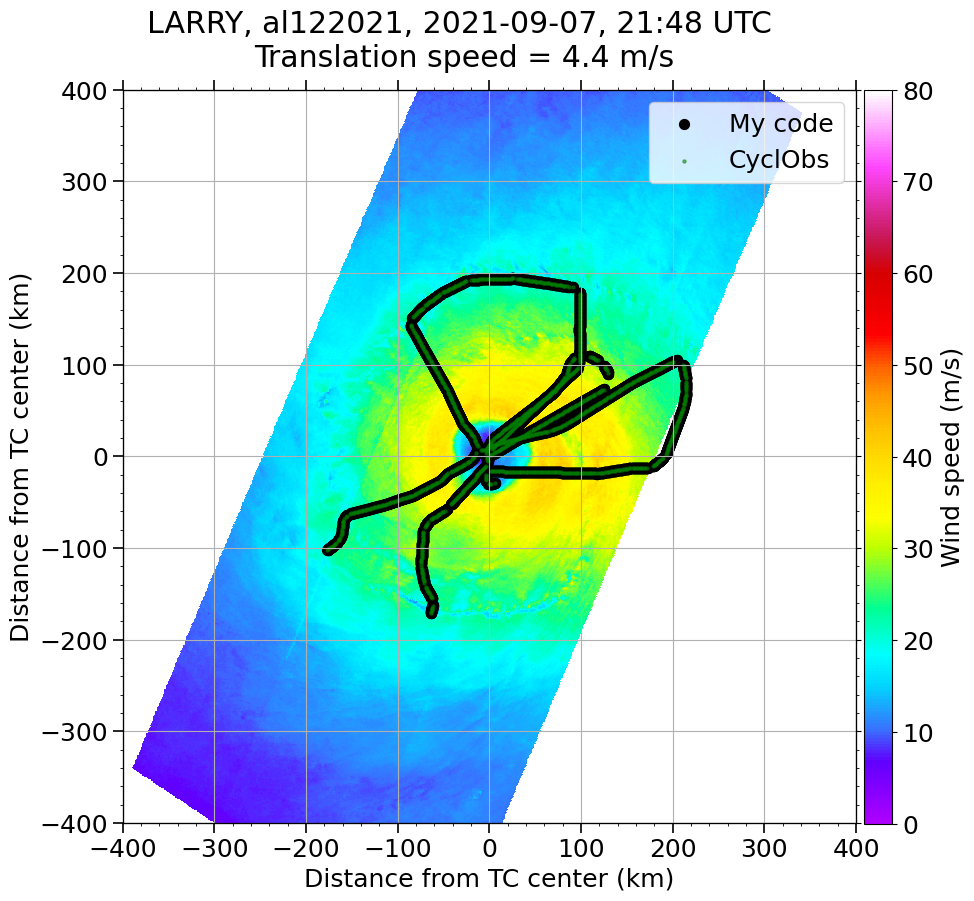

In [62]:
############
### Plot ###
############
fig          = plt.figure(figsize=(20, 20))
gs           = GridSpec(2, 1, hspace=0.1, wspace=0.01)
cmap         = mpl.cm.get_cmap('PuOr') # Spectral
normalizer   = Normalize(0, 80)
ax_lims2D    = 400
ts           = pd.to_datetime(str(ds.time.values)) 
d            = ts.strftime('%Y-%m-%d, %H:%M')
plt.suptitle('{}, {}, {} UTC \nTranslation speed = {:.1f} m/s'.format(ds.name.item(), ds.id.item(), d, ds.speed), y=0.92)

# ### Plot SAR
ax           = fig.add_subplot(gs[0, 0])
im           = ax.pcolormesh(dsc.x / 1000, dsc.y / 1000, dsc.wind_speed, cmap=cwnd, norm=normalizer)
# ax.scatter(diwp1.isel(height=34).x / 1000, diwp1.isel(height=34).y / 1000, c=diwp1.isel(height=34).hws, cmap=cwnd, norm=normalizer)

# 1. Plot ORIGINAL aircraft data (diwp1) - using small dots
ax.scatter(diwp1.isel(height=34).x / 1000, 
           diwp1.isel(height=34).y / 1000, 
           c='k', 
           s=50, label='My code')

# 2. Plot TRANSLATED aircraft data (translated_sfmr_df) - using larger bordered circles
# This shows the data relocalized to the SAR acquisition time
ax.scatter(translated_sfmr_df['x_km'][::10], 
           translated_sfmr_df['y_km'][::10], 
           c='green',
           s=5, alpha=0.5, label='CyclObs')

# Legend to distinguish the two
ax.legend(loc='upper right', frameon=True)

# Axes
ax.set_xlim(-ax_lims2D, ax_lims2D);ax.set_ylim(-ax_lims2D, ax_lims2D)
ax.set_ylabel(r'Distance from TC center (km)')
ax.set_xlabel(r'Distance from TC center (km)')
ax.set_box_aspect(1)
ax.minorticks_on()
ax.tick_params(length=7, width=1.2)
ax.grid()

ax2 = ax.twinx().twiny() 
ax2.set_xlim(-ax_lims2D, ax_lims2D);ax2.set_ylim(-ax_lims2D, ax_lims2D)
ax2.minorticks_on()
ax2.tick_params(axis='both', length=7, width=1.2)
ax2.set_box_aspect(1)
ax2.set_yticklabels([])
ax2.set_xticklabels([])

# Colorbar
cb_ax = fig.add_axes([0.7, 0.513, 0.014, 0.367])
cbar  = fig.colorbar(im, cax=cb_ax)
cbar.set_label(r'Wind speed (m/s)', rotation=90)
cbar.ax.get_yaxis().labelpad=5